In [51]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from gae.preprocessing import mask_test_edges
import scipy.sparse as sp
import netwulf as nw
from netwulf import visualize
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from preprocessGAE import mask_test_edges
from sklearn.metrics import accuracy_score

# 1. Preprocessing

#####  10% Validation and 20% Test Set Split in mask_test_edges impl from VGAE.

In [53]:
# Read Edgelist data using networkx
g = nx.read_edgelist('ChG-Miner_miner-chem-gene.tsv', delimiter='\t')

# make sure train-test split is consistent between notebooks by seeding to 0
np.random.seed(0) 

# SCIPY Data structure to store sparse matrix efficiently.
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test-val split using GAE preprocessing step
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj_sparse)

# Train networkx graph object with only non-hidden edges
g_train = nx.from_scipy_sparse_matrix(adj_train)
print(adj_sparse.shape)

(7341, 7341)


In [54]:
# train/test split
print ("Total nodes:", adj_sparse.shape[0])
print ("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print ("Training edges (positive):", len(train_edges))
print ("Validation edges (positive):", len(val_edges))
print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 7341
Total edges: 15138
Training edges (positive): 10598
Validation edges (positive): 1513
Validation edges (negative): 1513
Test edges (positive): 3027
Test edges (negative): 3027


In [55]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
    
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    acc=accuracy_score(labels_all, preds_all)
    return roc_score, ap_score, acc

### Adamic Adar

In [56]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj_sparse.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric   

In [57]:
print('Maximum Index : ' + str(aa_matrix.max()))
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

Maximum Index : 65.44035013081802


In [58]:
#Setting up threshold for AA index approx
thrarray=[0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
percentage1s=[]
for threshold in thrarray:
    i=0
    new_mat=aa_matrix >= threshold
    # treating all values satisfying above condition as 1 others 0
    #final_mat=new_mat.astype(int)
    #print(new_mat)
    final_mat=1*new_mat
    unique, counts = np.unique(final_mat, return_counts=True)
    d=dict(zip(unique, counts))
    percentage1s.append(d[1]/53890281*100)

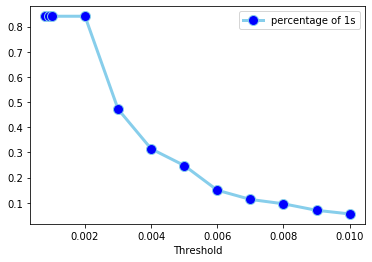

In [59]:
df1=pd.DataFrame({'x': thrarray, 
                 'perc': percentage1s
                  })

plt.plot( 'x', 'perc', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=3,label='percentage of 1s')
plt.legend()
plt.xlabel('Threshold')
plt.savefig('Miner_AA_Threshold.png', bbox_inches='tight')

In [60]:
#selecting the threshold based on the distribution of 1s in percentage
new_mat=aa_matrix >= 0.03
final_mat=1*new_mat

In [61]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap, acc = get_roc_score(test_edges, test_edges_false, final_mat)

print ('Adamic-Adar Test ROC score: ', str(aa_roc))
print ('Adamic-Adar Test AP score: ', str(aa_ap))
print ('Adamic-Adar Test Accuracy score: ', str(acc))


Adamic-Adar Test ROC score:  0.5
Adamic-Adar Test AP score:  0.5
Adamic-Adar Test Accuracy score:  0.5


### Resource Allocation

In [13]:
# Compute Resource-allocation indexes from g_train
ra_matrix = np.zeros(adj_sparse.shape)
for u, v, p in nx.resource_allocation_index(g_train): # (u, v) = node indices, p = Resource allocation index
    ra_matrix[u][v] = p
    ra_matrix[v][u] = p # make sure it's symmetric

In [14]:
print('Maximum Index : ' + str(ra_matrix.max()))

#Normalize
ra_matrix = ra_matrix / ra_matrix.max()

Maximum Index : 22.7297124113732


In [15]:
#Setting up threshold for AA index approx
thrarray=[0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
percentage1s=[]
for threshold in thrarray:
    i=0
    new_mat=ra_matrix >= threshold
    # treating all values satisfying above condition as 1 others 0
    #final_mat=new_mat.astype(int)
    #print(new_mat)
    final_mat=1*new_mat
    unique, counts = np.unique(final_mat, return_counts=True)
    d=dict(zip(unique, counts))
    percentage1s.append(d[1]/53890281*100)


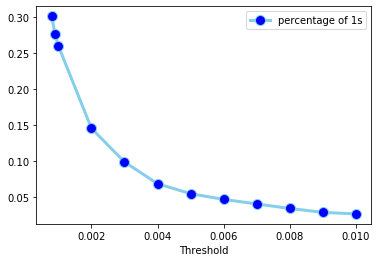

In [16]:
df1=pd.DataFrame({'x': thrarray, 
                 'perc': percentage1s
                  })

plt.plot( 'x', 'perc', data=df1, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=3,label='percentage of 1s')
plt.legend()
plt.xlabel('Threshold')
plt.savefig('Miner_RA_Threshold.png', bbox_inches='tight')

In [17]:
#selecting the threshold based on the distribution of 1s in percentage
new_mat=ra_matrix >= 0.02
final_mat=1*new_mat

In [18]:
###### Calculate ROC AUC and Average Precision
ra_roc, ra_ap, acc = get_roc_score(test_edges, test_edges_false, final_mat)

print ('Resource Allocation Test ROC score: ', str(ra_roc))
print ('Resource Allocation Test AP score: ', str(ra_ap))
print ('Resource Allocation Test Accuracy score: ', str(acc))

Resource Allocation Test ROC score:  0.5
Resource Allocation Test AP score:  0.5
